# TTA-45046 Financial Engineering
## Project Work 2017

Objective of the project work is to price OP Pohjola structured instrument OP Nokia Call 3/2017 using Monte Carlo simulation with antithetic variates. Underlying asset is Euro-nominated Nokia stock in Helsinki Stock Exchange

The terms of the contract are presented here: [OP Nokia Call 3/2017 Terms](https://uusi.op.fi/documents/20556/9985268/Lainaehdot+3+2017/74468110-5085-4496-bbdc-87e759dd3317) in Finnish. In short, in case stock price is greater than initial stock price at given observation dates contract terminates early and investor receives payoff according to the following formula

$$
NA \times (1 + i \times FR),
$$

where NA is the notional amount, FR is the fixed rate and i is the ordinal of the observation date.

In case of no early termination investor receives payoff in the following way: for given barrier level B,

1. if $\frac{S_T}{S_0} - 1 \geq 0$: investor receives $NA \times (1 + 6 \times FR)$.

2. if $0\ >\ \frac{S_T}{S_0} - 1 \geq B$: investor receives $NA$.

3. if $\frac{S_T}{S_0} - 1\ <\ B$: investor receives $\frac{S_T}{S_0} \times NA$.

In all three above described cases, the payment is made at maturity date T.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
from __future__ import division # Python 3 like division behaviour, easier to get floats

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For data wrangling
import requests
from bs4 import BeautifulSoup

# Constants
TRADING_DAYS = 252 # in a year
MATURITY = dt.datetime(2020, 4, 3) # contract's termination day

Pretending that we're doing this valuation on the effective date 15th of March 2017.

In [2]:
today = dt.datetime(2017, 3, 15)

## Estimating parameters

Most of the general parameters are already given, only asset specific parameters, like stock volatility, dividend yield and dividend distribution dates needs to be estimated.

According to project work instructions, to estimate Nokia stock volatility past one year data should be used.

I'll load the Nokia stock information from Nasdaq OMX homepage to estimate volatility. The file is already downloaded to the working directory and the name is 'NOKIA-2016-03-15-2017-03-15.csv'.

In [3]:
df = pd.read_csv('NOKIA-2016-03-15-2017-03-15.csv', sep=';', decimal=',', parse_dates=['Date'])
df.head()

,Date,Bid,Ask,Opening price,High price,Low price,Closing price,Average price,Total volume,Turnover,Trades
0,2017-03-15,4.98,4.99,4.98,5.01,4.97,4.99,4.99,13217726,65936757.39,6887
1,2017-03-14,4.98,4.98,5.00,5.01,4.96,4.98,4.98,13052841,65047032.05,7042
2,2017-03-13,4.99,4.99,5.00,5.01,4.98,5.00,4.99,11870070,59276069.25,5955
3,2017-03-10,4.99,4.99,4.96,5.01,4.94,4.99,4.99,15236854,75965143.28,8136
4,2017-03-09,4.95,4.96,4.88,4.97,4.87,4.95,4.94,18054074,89143715.03,8775


Estimate the stock volatility of log prices for the underlying asset.

In [4]:
daily_log_returns = np.log(1 + df['Closing price'].pct_change())
sigma = daily_log_returns.std() / np.sqrt(1 / TRADING_DAYS)
print 'Nokia stock volatility in 15-03-2016 - 15-03-2017 is {:.2f}'.format(sigma)

Nokia stock volatility in 15-03-2016 - 15-03-2017 is 0.31


To estimate Nokia's dividend information, I will get the information from Kauppalehti web page, but it's quite slow so the request for HTML data is placed into seperate cell.

In [5]:
url = 'https://www.kauppalehti.fi/5/i/porssi/osingot/osinkohistoria.jsp?klid=1050'
r = requests.get(url)

Then I will parse all the data into a pandas dataframe. I used this post  http://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table as a guide.

In [6]:
# Parse data
data = []
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all('table', attrs={'class':'table_stockexchange'})
rows = table[1].find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

# Set data into pandas dataframe
headers = ['year', 'date', 'adjusted_eur', 'amount', 'currency', 'yield']
df_dividend = pd.DataFrame(data[1:], columns=headers)

# Fix data types
numeric_data = ['year', 'adjusted_eur', 'amount', 'yield']
df_dividend[numeric_data] = df_dividend[numeric_data].apply(pd.to_numeric)
df_dividend['date'] = pd.to_datetime(df_dividend['date'])

df_dividend.head()

,year,date,adjusted_eur,amount,currency,yield
0,2017,2017-05-24,0.17,0.17,EUR,3.0
1,2016,2016-06-17,0.26,0.26,EUR,5.1
2,2015,2015-06-05,0.14,0.14,EUR,2.4
3,2014,2014-06-18,0.37,0.37,EUR,6.3
4,2013,2013-08-05,0.00,0.00,EUR,0.0


First I estimate the dividend yield of Nokia stock. According to the project work instructions one should use last five years data to estimate the dividend yield.

In [7]:
estimation_period = 5
div_yield = df_dividend['yield'][:estimation_period].mean() / 100
print 'The mean dividend yield during the last five years: {}'.format(div_yield * 100)

The mean dividend yield during the last five years: 3.36


Next I will estimate the dividend paying date by taking the mean dividend distribution date of last five years. Then calculate future dividend distribution dates during the maturity of the derivative contract. I am still using the five-year estimation period for the date calculations.

In [8]:
years = pd.to_datetime(df_dividend['year'], format='%Y')
mean_dividend_date = (df_dividend['date'][:estimation_period] - 
                      years[:estimation_period]).mean()

dividend_dates = [dt.datetime(year, 1, 1) + 
                  mean_dividend_date for year in range(2017, 2020)]
print 'Estimated dividend paying dates:', 
print [date.strftime('%d.%m.%Y') for date in dividend_dates]

Estimated dividend paying dates: ['20.06.2017', '20.06.2018', '20.06.2019']


Then I will change these dates into linear time, the effective day as the starting point. Since the dates are estimated as calendar days so I will divide by whole calendar year (365 days, thank god no leap year in the time period), not by amount of trading days.

In [9]:
div_dates = np.array([(date - today).days for date in dividend_dates]) / 365
print 'In linear time dividends are distributed at the following times:', div_dates

In linear time dividends are distributed at the following times: [ 0.26575342  1.26575342  2.26575342]


Now I will set the rest parameters given in the project work instructions document.

In [10]:
notional_amount = 1000
fixed_rate = 0.084
barrier = -0.30
rf = 0.001 # risk-free rate
n_sim = int(1e6)

# These dates are in linear times from the effective date
obs_dates = np.array([6/12 - 1/252, 1 - 2/252, 1 + 6/12 - 1/252, 
                      2, 2 + 6/12 + 1/252, 3 + 2/252])
pay_dates = np.array([6/12 + 12/252, 1 + 12/252, 1 + 6/12 + 12/252, 
                      2 + 12/252, 2 + 6/12 + 12/252, 3 + 12/252])

S0 = df['Closing price'][0] # Inial asset price
TIMESTEPS = len(obs_dates)

## Reference solution

Following solution is done mainly according to the instructions in the project work document: both traditional Monte Carlo and antithetic Monte Carlo stock price paths are simulated one time period at time and then early termination condition is checked for each path. In case of early termination or reaching maturity payoff of that simulation is calculated. Only difference to the original instructions is that when next period is dividend paying date, instead of estimating dividends at future date, discounting it back in the 'current time'  and then subtracting it from the original stock price, stock price is also simulated at dividend distributing dates and then directly subtracted from the stock price at dividend paying date. 

Following function determines the coefficient that the investor is paid in maturity given the barrier level, fixed rate, initial and final stock price.

In [11]:
def maturity_termination_coefficient(S, S0, barrier, fixed_rate):
    
    coefficient = (S / S0) - 1

    # Stock price finally is higher than initial stock price
    if coefficient >= 0:
        return (1 + TIMESTEPS * fixed_rate)
    
    # Stock price less than initial stock price 
    # but coefficient is higher than the given barrier
    elif coefficient >= barrier:
        return 1
    
    # Stock price at maturity / initial stock price coefficient 
    # is less than the given barrier
    else:
        return (coefficient + 1)

Next is the simulation of stock price processes and calculation of payoffs for the contract.

In [12]:
%%time
# Linear time difference between each date
all_dates = np.hstack((0, np.hstack((div_dates, obs_dates))))
all_dates = np.sort(all_dates)
dT = np.hstack((0, np.diff(all_dates)))
div_mask = np.in1d(all_dates, div_dates)

payoffs = np.zeros(n_sim)
payoffs_at = np.zeros(n_sim) # antithetic payoffs

# simulations
for i in range(n_sim):
    
    s = S0
    s_at = S0
    terminated_early = False
    at_terminated_early = False
    
    # stock price process
    for j in range(1, len(dT)):
        
        eps = np.random.randn()
        
        # traditional Monte Carlo
        if not terminated_early:
            
            # simulate next stock price
            x = (rf - 0.5 * sigma ** 2) * dT[j] + sigma * np.sqrt(dT[j]) * eps
            s *= np.exp(x)
            
            # if dividend distribution date decrease stock price by distributed dividend
            if(div_mask[j]):
                s *= (1 - div_yield)
                        
            # check if at maturity
            elif j == len(dT) - 1:
                coeff = maturity_termination_coefficient(s, S0, barrier, fixed_rate)
                payoffs[i] = notional_amount * np.exp(-rf * all_dates[j]) * coeff
                
            # check early termination condition for traditional Monte Carlo
            elif s > S0:
                obs_per = j - (all_dates[div_mask] < all_dates[j]).sum()
                coeff = (1 + obs_per * fixed_rate)
                payoffs[i] = notional_amount * np.exp(-rf * all_dates[j]) * coeff
                terminated_early = True
        
        # antithetic Monte Carlo
        if not at_terminated_early:
            
            # simulate next stock price
            x_at = (rf - 0.5 * sigma ** 2) * dT[j] - sigma * np.sqrt(dT[j]) * eps
            s_at *= np.exp(x_at)
        
            # if dividend distribution date decrease stock price by distributed dividend
            if(div_mask[j]):
                s_at *= (1 - div_yield)
        
            # check if at maturity
            elif j == len(dT) - 1:
                coeff = maturity_termination_coefficient(s_at, S0, barrier, fixed_rate)
                payoffs_at[i] = notional_amount * np.exp(-rf * all_dates[j]) * coeff
        
            # check early termination condition for Antithetic Monte Carlo
            elif s_at > S0:
                obs_per = j - (all_dates[div_mask] < all_dates[j]).sum()
                coeff = (1 + obs_per * fixed_rate)
                payoffs_at[i] = notional_amount * np.exp(-rf * all_dates[j]) * coeff
                at_terminated_early = True
        
        # both payoffs are already calculated, no further simulations needed
        if terminated_early and at_terminated_early:
            break

    # adjustment of antithetic payoffs
    payoffs_at[i] = (payoffs[i] + payoffs_at[i]) / 2

CPU times: user 1min 42s, sys: 672 ms, total: 1min 43s
Wall time: 1min 42s


By simulating stock price one period at a time, for 1,000,000 simulations calculating contract price takes about almost two minutes, which is not unbearable since this simulation do not need to be done in real time during trading.

### Results

Using traditional Monte Carlo methods
Mean of derivative price: 949.434801783
Std of derivative price: 320.674465942

Using Antithetic Monte Carlo methods
Mean of derivative price: 949.497560211
Std of derivative price: 195.41834585


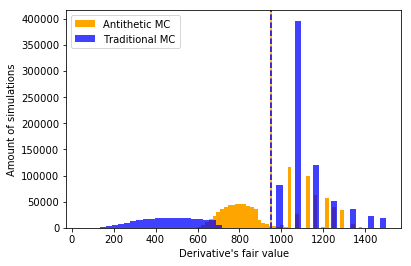

In [13]:
print 'Using traditional Monte Carlo methods'
print 'Mean of derivative price:', payoffs.mean()
print 'Std of derivative price:', payoffs.std()
print 
print 'Using Antithetic Monte Carlo methods'
print 'Mean of derivative price:', payoffs_at.mean()
print 'Std of derivative price:', payoffs_at.std()


# Plot histograms of price distribution
plt.hist(payoffs_at, label='Antithetic MC', color='orange', bins=50)
plt.axvline(payoffs_at.mean(), color='orange', linestyle='solid', linewidth=1.5)
plt.hist(payoffs, label='Traditional MC', color='blue', bins=50, alpha=0.75)
plt.axvline(payoffs.mean(), color='blue', linestyle='dashed', linewidth=1.5)

plt.xlabel("Derivative's fair value")
plt.ylabel('Amount of simulations')
plt.legend()
plt.show()

Two important points can be obtained from the results:

1. Technicaility-wise pricing the derivative using Monte Carlo with antithetic variates greatly decreases the volatility of the results, which was expected as it is the main contribution of the algorithm. You can see this behaviour also from the graph as there are less extreme values and the probability mass is more concentraded in the middle.  

2. Pricing-wise OP Pohjola on average is making a profit of 50 euros per contract, since notional amount is 1000 euros. This is because the profits over 1000 euros have discrete outcomes, thus investor's up-side is limited.

Personally I found profit of about 5% very small since I was expecting marketing costs, salaries of both sales and trading side, and also transaction costs for later hedging would be much higher. Presumably, huge amount of contracts (13,090) will provide healthy profit. Also since OP Pohjola has other contracts, hedging positions can cancel each other out, thus hedging less is needed.

## Optimized solution with vectorization
### Stock price process with dividends

Stock price process follows geometric brownian motion

$$ S_{t+ \Delta t} = S_t \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_t }.$$

But there is also need to adjust stock price process for dividends as of follows

$$ S^*_{\tau_i} = S_{\tau_i} - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i) }\ \times Q_{\tau_i;\tau_{i+1}},$$ 

where $S^*$ is dividend adjusted stock price, $T_{div_{\tau_i;\tau_{i+1}}}$ dividend distribution time and $Q_{\tau_i;\tau_{i+1}}$ is the amount of dividend. In the instructions it is proposed to first check the early termination condition at the initial step, then adjust possible dividend and finally calculate stock price at the next step. 

However, because of vectorization I first simulate the stock prices paths without dividends and I need to adjust the dividends.

$$ S^*_{t+ \Delta t} = S_t^* \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_t }, $$

where we apply dividend adjusted geometric brownian motion.

$$ S^*_{\tau_i+ \Delta t} = 
    (S_{\tau_i} 
    - e^{-r (T_{div_{\tau_i;\\\tau_{i+1}}} - \tau_i)}\ 
        \times Q_{\tau_i;\tau_{i+1}}) 
    \times\ e^{(r - \frac{1}{2} \sigma^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i} }$$

$$
S^*_{\tau_i+ \Delta t} = 
    S_{\tau_i} 
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
    - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i)}\ 
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{\tau_i;\tau_{i+1}},
$$

where $S_{\tau_i}e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}$ is the original geometric brownian motion. Consequently,

$$
S^*_{\tau_i+ \Delta t} = 
    S_{t+ \Delta t}
    - e^{-r (T_{div_{\tau_i;\tau_{i+1}}} - \tau_i)}\  
        \times\ e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{\tau_i;\tau_{i+1}},
$$

so first I need to discount the amount of dividend to previous observation date and then apply the diffusion process, however as stock price is also simulated at dividend distribution dates discounting is not necessary, thus finally 

$$
S^*_{t_i+ \Delta t} = 
    S_{t+\Delta t}
    - e^{(r - \frac{1}{2} \sigma)\Delta t  + \sigma \sqrt{\Delta t} \epsilon_{t_i}}
        \times Q_{t}
$$

In brief I need to make same kind of diffusion process for dividends as for the stock price from distribution date onwards and subtract the amount of dividend in the future dates.

In [14]:
def simulate_stock_price_paths(S0, sigma, obs_dates, div_dates, div_yield, rf, n_sim):
    
    # Linear time difference between each date
    all_dates = np.hstack((0, np.hstack((div_dates, obs_dates))))
    all_dates = np.sort(all_dates)
    dT = np.diff(all_dates)

    # Generate the random variables 
    # (stock price pathes are vertical, simulations horizontal)
    eps = np.random.randn(n_sim, len(dT))

    # Traditional Monte Carlo stock price paths
    Xt = (rf - 0.5 * sigma ** 2) * dT + sigma * np.sqrt(dT) * eps
    Xt = np.hstack((np.zeros((n_sim, 1)), np.cumsum(Xt, axis=1)))
    St = (S0 * np.exp(Xt))

    # Antithetic Monte Carlo stock price paths
    Xt_at = (rf - 0.5 * sigma ** 2) * dT - sigma * np.sqrt(dT) * eps
    Xt_at = np.hstack((np.zeros((n_sim, 1)), np.cumsum(Xt_at, axis=1)))
    St_at = S0 * np.exp(Xt_at)

    # Adjusting for dividends
    for div_date in div_dates:

        # Find out correct time in terms of all dates
        index = (np.where(all_dates == div_date))[0][0]
  
        # Amount of distributed dividend
        Q = St[:,index] * div_yield 

        # Apply dividends to the stock price processes
        Xt_temp = (Xt.T - Xt[:,index]).T # diffusion process from dividend date onwards
        Qt = (Q * np.exp(Xt_temp[:,index:]).T).T # dividend's price process
        St[:,index:] -= Qt

        # And the same adjustment for antithetic paths
        Xt_at_temp = (Xt_at.T - Xt_at[:,index]).T
        Q_at = St_at[:,index] * div_yield
        Qt_at = (Q_at * np.exp(Xt_at_temp[:,index:]).T).T
        St_at[:,index:] -= Qt_at

    
    # Mask to filter out dividend dates from stock price process
    div_mask = np.in1d(all_dates, div_dates)

    return St[:, ~div_mask], St_at[:, ~div_mask]

### Pricing

According to instructions contract will early terminate in case stock price is greater than stock price at t=0 at any observation date, otherwise contract terminate at maturity. This function returns the correct period when contract will terminate given stock price path.

In [15]:
def determine_termination_period(St):
    ter_period = np.argmax(St.T > St[:,0], axis=0)
    ter_period[ter_period == 0] = TIMESTEPS # no early termination
    return ter_period

This function determines coefficient for the payoff at the maturity (no early termination). Coefficient is used later to calculate contract's payoff at the maturity.

In [16]:
def maturity_termination_coefficient(St, barrier, fixed_rate):
    
    coefficients = np.empty_like(St[:,0], dtype=float)
    ratios = (St[:,-1] / St[:,0]) - 1
    
    # Stock price finally is higher than initial stock price
    coefficients[ratios >= 0] = (1 + TIMESTEPS * fixed_rate)
    
    # Stock price at maturity / initial stock price coefficient 
    # is less than the given barrier
    coefficients[ratios < barrier] = (ratios[ratios < barrier] + 1)
    
    # Stock price less than initial stock price but coefficient 
    # is higher than the given barrier
    coefficients[(ratios < 0) & (ratios >= barrier)] = 1

    return coefficients

This function calculates the payoff of the structured instrument given the stock price path taking into account different termination periods.

In [17]:
def calculate_payoff(St, pay_dates, fixed_rate, barrier, notional_amount, rf):
    
    payoffs = np.zeros_like(St[:,0], dtype=float)
    
    # Determine stock price path's termination period
    termination_period = determine_termination_period(St)
    
    # Payoff at maturity
    maturity = (termination_period == TIMESTEPS)
    payoffs[maturity] = maturity_termination_coefficient(St[maturity], barrier, 
                                                         fixed_rate) * notional_amount
    
    # Early termination payoffs
    payoffs[~maturity] = notional_amount * (1 + termination_period[~maturity] * fixed_rate)
    
    # discounting
    dT = pay_dates[termination_period - 1]
    return payoffs * np.exp(-rf * dT)

Function to run the pricing algorithm.

The function returns n_sim amount of prices, both using antithetic variates and only traditional Monte Carlo methods.

In [18]:
def price_derivative(S0, sigma, obs_dates, pay_dates, div_dates, div_yield, barrier,
                     fixed_rate, notional_amount, rf, n_sim):
    
    # Simulate dividend-adjusted stock price paths
    St, St_at = simulate_stock_price_paths(S0, sigma, obs_dates,
                                           div_dates, div_yield, rf, n_sim)
    
    # Apply pricing algorithm
    prices = calculate_payoff(St, pay_dates, fixed_rate, barrier, notional_amount, rf)
    prices_at = calculate_payoff(St_at, pay_dates, fixed_rate, barrier, notional_amount, rf)
    
    # Antithetic Monte Carlo adjustment
    prices_at = (prices_at + prices) / 2
        
    return prices_at, prices

In [19]:
%%time
prices_at, prices = price_derivative(S0, sigma, obs_dates, pay_dates, div_dates, div_yield,
                                      barrier, fixed_rate, notional_amount, rf, n_sim)

CPU times: user 2.85 s, sys: 424 ms, total: 3.28 s
Wall time: 3.27 s


For 1,000,000 simulations function takes around 3 seconds to run, thus optimized version only takes 3% of the time the original solution requires. Vectorization makes a huge difference.

### Results

Using traditional Monte Carlo methods
Mean of derivative price: 949.534640372
Std of derivative price: 320.516508222

Using Antithetic Monte Carlo methods
Mean of derivative price: 949.523978779
Std of derivative price: 195.377219753


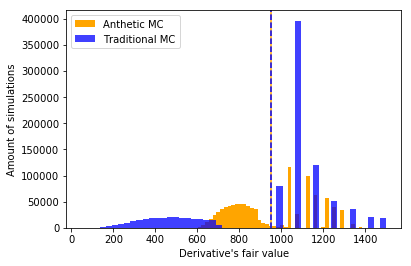

In [20]:
print 'Using traditional Monte Carlo methods'
print 'Mean of derivative price:', prices.mean()
print 'Std of derivative price:', prices.std()
print 
print 'Using Antithetic Monte Carlo methods'
print 'Mean of derivative price:', prices_at.mean()
print 'Std of derivative price:', prices_at.std()


# Plot histograms of price distribution
plt.hist(prices_at, label='Anthetic MC', color='orange', bins=50)
plt.axvline(prices_at.mean(), color='orange', linestyle='solid', linewidth=1.5)
plt.hist(prices, label='Traditional MC', color='blue', bins=50, alpha=0.75)
plt.axvline(prices.mean(), color='blue', linestyle='dashed', linewidth=1.5)

plt.xlabel("Derivative's fair value")
plt.ylabel('Amount of simulations')
plt.legend()
plt.show()

We also attain the same results.

## Sensitivity analysis

Finally here is a sensitivity analysis volatility set at 80%, 100% and 120% of original estimated volatility.

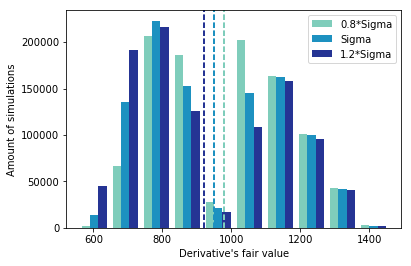

In [21]:
sigmas = [0.8*sigma, sigma, 1.2*sigma]
prices = np.array([price_derivative(S0, sig, obs_dates, pay_dates, div_dates, div_yield, 
                                      barrier, fixed_rate, notional_amount, rf, n_sim)[0]
                   for sig in sigmas])

data = [prices[i] for i in range(len(sigmas))]

labels = ['0.8*Sigma', 'Sigma', '1.2*Sigma']
colors = ['#7fcdbb', '#1d91c0', '#253494']

plt.hist(data, histtype='bar', label=labels, color=colors)
for i in range(len(data)):
    plt.axvline(data[i].mean(), color=colors[i], linestyle='dashed', linewidth=2)

plt.legend()
plt.xlabel("Derivative's fair value")
plt.ylabel('Amount of simulations')
plt.show()

The graph tells that the lower the volatility the higher the derivative's fair value and vice versa. Thus one could make an educated guess that OP Pohjola expects Nokia stock's volatility increase in the coming years.